In [1]:
pip install adversarial-robustness-toolbox

Note: you may need to restart the kernel to use updated packages.


In [2]:
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent
from art.metrics import empirical_robustness
import timeit
from art.estimators.classification import PyTorchClassifier
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split, TensorDataset
from torch.nn.functional import nll_loss
from torchvision import transforms, datasets
from torch.autograd import Variable
from torch.nn.functional import nll_loss
import os
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
import src.model as md
from src.model import Network
from src.model import ConvLayer
import src.dataLoad as dL

In [4]:
os.chdir("./src")

In [5]:
dL.load()
data = dL.preprocessing()

Already Completed


In [6]:
# DataLoader type
train_data = data["train_load"]
test_data = data["test_load"]

In [7]:
train_x = np.array([])
train_y = np.array([])

for data in train_data:
#     print(np.array(data[0].unsqueeze(0).shape))
#     break
    if train_x.size == 0:
        train_x = np.array(data[0])
    else:
        train_x = np.concatenate((train_x, np.array(data[0])), axis=0)
    train_y = np.append(train_y, data[1])

In [8]:
test_x = np.array([])
test_y = np.array([])

for data in test_data:
#     print(np.array(data[0].unsqueeze(0).shape))
#     break
    if test_x.size == 0:
        test_x = np.array(data[0])
    else:
        test_x = np.concatenate((test_x, np.array(data[0])), axis=0)
    test_y = np.append(test_y, data[1])

In [9]:
test_x.shape

(34, 1, 150, 150)

In [10]:

os.getcwd()

'/Users/kwontaeyoon/Desktop/WorkSpace/github/Yale-FaceRecognition/src'

In [11]:
model_init = torch.load("../model/model.pt")

In [12]:
classifier = PyTorchClassifier(model=model_init,
                                    nb_classes=15,
                                    clip_values=(0.0, 1.0),
                                    input_shape=tuple(train_x[0][0].shape[1:]),
                                    loss=torch.nn.CrossEntropyLoss())

In [13]:
train_x_pred = classifier.predict(train_x)
test_x_pred = classifier.predict(test_x)
print(test_x_pred.shape)

/Users/kwontaeyoon/opt/anaconda3/envs/ai21/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-accccgfm/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/Users/kwontaeyoon/Desktop/WorkSpace/github/Yale-FaceRecognition/src/model.py:50: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return nn.functional.log_softmax(self.fully_connected2(x))


(34, 15)


In [14]:
FGM = FastGradientMethod(classifier, norm = "inf", 
                        eps=0.2, eps_step=0.1, targeted=False,
                        num_random_init=0,
                        batch_size=16,
                        minimal=True)

start = timeit.default_timer()
train_x_adv = FGM.generate(train_x)
test_x_adv = FGM.generate(test_x)
stop = timeit.default_timer()

print('Time: ', stop - start)

train_y_adv = classifier.predict(train_x_adv)
test_y_adv = classifier.predict(test_x_adv)

Time:  18.034489632999996


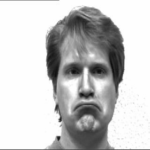

In [15]:
original_image = Image.fromarray((train_x[10]*255).astype(np.uint8).squeeze())
FGM_image = Image.fromarray((train_x_adv[10]*255).astype(np.uint8).squeeze())
original_image

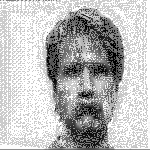

In [16]:
FGM_image

In [17]:
correct = 0
index = 0
for predict in test_x_pred:
    pred = np.argmax(predict)
    if pred == test_y[index]:
        correct += 1
  
    index += 1

print("ORIGINAL Accuracy : " + str(correct/len(test_x_pred)))

correct = 0
index = 0
for predict in test_y_adv:
    pred = np.argmax(predict)
    if pred == test_y[index]:
        correct += 1
  
    index += 1

print("FGM Accuracy : " + str(correct/len(test_x_pred)))

ORIGINAL Accuracy : 1.0
FGM Accuracy : 0.47058823529411764


In [18]:
tensorX = torch.tensor(train_x_adv)
tensorY = torch.tensor(train_y)
tensorY = tensorY.long()
dataset_train_FGM = TensorDataset(tensorX, tensorY)
train_FGM_loader = DataLoader(dataset_train_FGM,
                         batch_size = 16, shuffle=False)

In [19]:
for (img,label), (img2,label2) in zip(train_data, train_FGM_loader) :
    print(label,label2)
    break

tensor([ 2,  3,  1,  6,  7,  6,  7, 14,  9,  7,  0, 12,  6,  6, 10, 11]) tensor([ 2,  3,  1,  6,  7,  6,  7, 14,  9,  7,  0, 12,  6,  6, 10, 11])


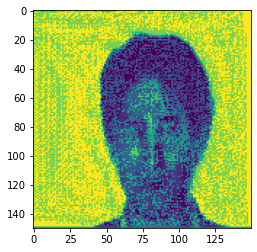

In [20]:
for i,(img,label) in enumerate(train_data):
#     img, label = Variable(img), Variable(label)
#     print(img)
    plt.imshow(img.squeeze(1)[0])
    break
for i, (img,label) in enumerate(train_FGM_loader) :
    plt.imshow(img.squeeze(1)[0])
    break

In [21]:
model = md.Network()
optimizer = optim.Adam(model.parameters(),0.001)

In [22]:
epoch = 100
model.train()
for i in range(epoch):
    loss_data = []
    for (img,label), (img2,label2) in zip(train_data, train_FGM_loader) :
        img, label = Variable(img), Variable(label)
        img2, label2 = Variable(img2), Variable(label2)
        optimizer.zero_grad()
        
        output1 = model(img)
        loss1 = nll_loss(output1,label)
        output2 = model(img2)
        loss2 = nll_loss(output2,label)
        
        loss = (0.5 * loss1) + (0.5 * loss2)
        
        loss.backward()
        optimizer.step()
        loss_data.append(loss.data)
    print('Train Epoch: {} \tLoss: {:.6f}'.format(i, np.mean(loss_data)))

Train Epoch: 0 	Loss: 3.264372
Train Epoch: 1 	Loss: 2.697137
Train Epoch: 2 	Loss: 2.150023
Train Epoch: 3 	Loss: 1.909432
Train Epoch: 4 	Loss: 1.608682
Train Epoch: 5 	Loss: 1.393833
Train Epoch: 6 	Loss: 1.197162
Train Epoch: 7 	Loss: 1.047603
Train Epoch: 8 	Loss: 0.916123
Train Epoch: 9 	Loss: 0.809371
Train Epoch: 10 	Loss: 0.718139
Train Epoch: 11 	Loss: 0.638279
Train Epoch: 12 	Loss: 0.569555
Train Epoch: 13 	Loss: 0.509470
Train Epoch: 14 	Loss: 0.456047
Train Epoch: 15 	Loss: 0.408389
Train Epoch: 16 	Loss: 0.366579
Train Epoch: 17 	Loss: 0.328516
Train Epoch: 18 	Loss: 0.294752
Train Epoch: 19 	Loss: 0.264443
Train Epoch: 20 	Loss: 0.237136
Train Epoch: 21 	Loss: 0.212874
Train Epoch: 22 	Loss: 0.191151
Train Epoch: 23 	Loss: 0.171669
Train Epoch: 24 	Loss: 0.154267
Train Epoch: 25 	Loss: 0.139123
Train Epoch: 26 	Loss: 0.125620
Train Epoch: 27 	Loss: 0.113681
Train Epoch: 28 	Loss: 0.103173
Train Epoch: 29 	Loss: 0.093932
Train Epoch: 30 	Loss: 0.085739
Train Epoch: 31 	L

In [23]:
classifier2 = PyTorchClassifier(model=model,
                                    nb_classes=15,
                                    clip_values=(0.0, 1.0),
                                    input_shape=tuple(train_x[0][0].shape[1:]),
                                    loss=torch.nn.CrossEntropyLoss())
test_y_pred = classifier2.predict(test_x)
test_y_adv_pred = classifier2.predict(test_x_adv)

In [24]:
correct = 0
index = 0
for predict in test_y_pred:
    pred = np.argmax(predict)
    if pred == test_y[index]:
        correct += 1
  
    index += 1

print("ORIGINAL Accuracy : " + str(correct/len(test_y_pred)))

correct = 0
index = 0
for predict in test_y_adv_pred:
    pred = np.argmax(predict)
    if pred == test_y[index]:
        correct += 1
  
    index += 1

print("FGM Accuracy : " + str(correct/len(test_y_adv)))

ORIGINAL Accuracy : 0.8823529411764706
FGM Accuracy : 0.8529411764705882


In [46]:
# torch.save(model,"../model/fgm_model.pt")
# os.getcwd()

'/Users/kwontaeyoon/Desktop/WorkSpace/github/Yale-FaceRecognition/src'